<a href="https://colab.research.google.com/github/LeeSeungwon89/Deep-learning_Theory/blob/main/9-3%20LSTM%EA%B3%BC%20GRU%20%EC%85%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **9-3 LSTM과 GRU 셀**

**LSTM(Long Short-Term Memory)**과 **GRU(Gated Recurrent Unit)**는 SimpleRNN보다 계산이 훨씬 복잡한 고급 순환층입니다. 성능이 뛰어나서 순환 신경망에 많이 채택됩니다. 일반적으로 기본 순환층은 긴 시퀀스를 학습하기 어렵습니다. 긴 시퀀스일수록 순환되는 은닉 상태에 담긴 정보가 점점 희석되어 멀리 떨어져 있는 단어 정보를 인식하는 데 어려워지기 때문입니다. 이런 문제를 해결하기 위해 사용되는 것이 바로 LSTM과 GRU입니다.

## **LSTM 구조**

LSTM은 단기 기억을 오래할(long short-term memory) 목적으로 고안된 방법입니다. 

LSTM의 구조를 설명하겠습니다. 기본 개념은 동일합니다. 입력과 가중치를 곱하고 절편을 더해서 활성화 함수를 통과시키는 구조를 여러 개 가지고 있습니다. 이렇게 계산된 결과는 다음 타임스텝에 재사용됩니다. 

은닉 상태는 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱하고 활성화 함수를 통과시켜 다음 은닉 상태를 만듭니다. 이때 기본 순환층과 달리 시그모이드 활성화 함수를 사용합니다. 또 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만듭니다. 이 은닉 상태에 대해서는 아래에서 추가로 설명하겠습니다. 먼저 아래 그림(출처: 본서)을 첨부하겠습니다.

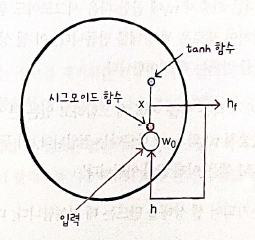

편의상 $w_o$은 은닉 상태를 계산할 때 사용하는 가중치 $w_x$와 $w_h$를 통틀어 표현한 것입니다. x는 곱셈을 의미하며, $h$는 은닉 상태입니다. (캡쳐한 이미지의 색상이 흐릿하여 명확히 구분되지 않지만) 시그모이드 함수는 적색 동그라미, tanh 함수는 파란색 동그라미입니다. 기본 순환층과 다르지 않은 형태입니다. 여기서 tanh 함수를 통과하는 값이 무엇인지 설명할 필요가 있습니다. LSTM에는 순환되는 상태가 2개(은닉 상태, **셀 상태(cell state)**)입니다. 셀 상태는 다음 층으로 전달되지 않고 LSTM 셀에서만 순환되는 값입니다. 아래 그림(출처: 본서)을 주목하시기 바랍니다.

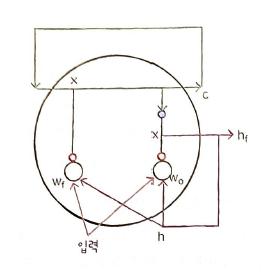

셀 상태는 $c$입니다. 이 셀 상태를 계산하는 과정을 서술하겠습니다. 먼저 입력과 은닉 상태를 또 다른 가중치 $w_f$($w_o$와 다른 값)와 곱하고 시그모이드 함수를 통과시킵니다. 그 후 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태를 만듭니다. 이 셀 상태가 오른쪽에서 tanh 함수를 통과하여 새로운 은닉 상태를 만드는 데 기여합니다. 이는 작은 셀을 여러 개 포함하는 큰 셀처럼 생각할 수 있습니다. 이 두 작은 셀은 각기 다른 기능을 위해 훈련됩니다. 여기에 작은 셀 2개가 더 추가되어 셀 상태를 만드는 데 기여하는 그림(출처: 본서)을 첨부하겠습니다.

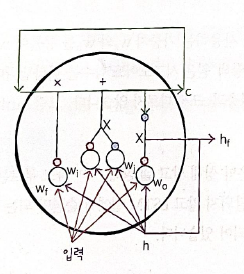

가운데에 작은 셀 2개가 추가됐습니다. 입력과 은닉 상태를 다른 가중치에 곱하는 과정은 같지만 하나는 시그모이드 함수를 통과시키고 하나는 tanh 함수를 통과시킵니다. 그리고 두 결과를 곱하여 이전 셀 상태와 더하면 최종적인 다음 셀 상태가 만들어집니다. 마지막으로 아래 그림(출처: 본서)을 첨부하겠습니다.

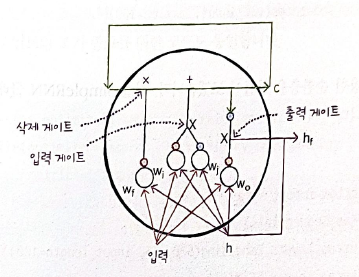

각 곱셈마다 고유 명칭을 가집니다. 삭제 게이트는 셀 상태에 있는 정보를 제거합니다. 입력 게이트는 새로운 정보를 셀 상태에 추가합니다. 출력 게이트는 이 셀 상태가 다음 은닉 상태로 출력되게 합니다.

## **LSTM 신경망 훈련하기**

IMDB 리뷰 데이터를 준비하겠습니다. 이전 챕터에서 수행한 과정과 동일합니다.

In [ ]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

# 샘플 길이를 100으로 지정합니다.
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

17473536/17464789 [==============================] - 0s 0us/step


LSTM 셀을 사용한 순환층을 생성해 보겠습니다. `SimpleRNN` 클래스 대신 `LSTM` 클래스를 구성하며, 임베딩을 사용했던 순환 신경망 모델과 동일합니다. 

In [ ]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


`SimpleRNN` 클래스의 모델 파라미터 개수는 200개였지만 `LSTM` 셀에는 작은 셀이 4개 있으므로 4배가 곱해져 800개입니다.

모델을 컴파일하고 훈련해 보겠습니다. 이전 챕터에서 사용했던 하이퍼 파라미터와 체크포인트, 조기 종료를 그대로 사용하겠습니다.

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 20s 47ms/step - loss: 0.6921 - accuracy: 0.5518 - val_loss: 0.6909 - val_accuracy: 0.5858
Epoch 2/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6891 - accuracy: 0.6097 - val_loss: 0.6869 - val_accuracy: 0.6292
Epoch 3/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6816 - accuracy: 0.6546 - val_loss: 0.6746 - val_accuracy: 0.6720
Epoch 4/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6482 - accuracy: 0.6978 - val_loss: 0.6114 - val_accuracy: 0.7162
Epoch 5/100
313/313 [==============================] - 15s 47ms/step - loss: 0.5813 - accuracy: 0.7285 - val_loss: 0.5707 - val_accuracy: 0.7272
Epoch 6/100
313/313 [==============================] - 20s 65ms/step - loss: 0.5519 - accuracy: 0.7451 - val_loss: 0.5460 - val_accuracy: 0.7456
Epoch 7/100
313/313 [==============================] - 17s 54ms/step - loss: 0.5285 - accuracy: 0.7599 - val_loss: 0.5247 - val_ac

훈련 손실과 검증 손실을 시각화해 보겠습니다.

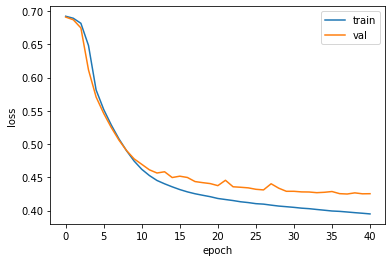

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

비교적으로 LSTM 층이 기본 순환층보다 과대적합을 잘 억제합니다. 다만 경우에 따라 과대적합을 더 강하게 제어할 필요도 있습니다. 아래 파트에서 드롭아웃을 적용해 보겠습니다.

## **순환층에 드롭아웃 적용하기**

완전 연결 신경망과 합성곱 신경망에서는 `Dropout` 클래스를 사용하여 드롭아웃을 적용하여 모델이 훈련 데이터 세트에 과대적합되지 않도록 조치했습니다. 반면 순환층을 생성하는 `SimpleRNN`과 `LSTM` 클래스는 매개변수인 `dropout`과 `recurrent_dropout`으로 드롭아웃 기능을 제공합니다. `dropout` 매개변수는 셀 입력에 드롭아웃을 적용하고, `recurrent_dropout` 매개변수는 은닉 상태에 드롭아웃을 적용합니다. 그러나 `recurrent_dropout` 매개변수를 지정하면 GPU로 모델 훈련을 수행할 수 없습니다. `dropout` 매개변수만 사용하여 드롭아웃을 적용해 보겠습니다.

모델 구조는 전과 같습니다. 드롭아웃을 30%만큼 적용하겠습니다.

In [ ]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

위와 동일한 코드로 모델을 훈련해 보겠습니다.

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 20s 56ms/step - loss: 0.6928 - accuracy: 0.5206 - val_loss: 0.6924 - val_accuracy: 0.5468
Epoch 2/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6914 - accuracy: 0.5810 - val_loss: 0.6906 - val_accuracy: 0.5928
Epoch 3/100
313/313 [==============================] - 19s 61ms/step - loss: 0.6885 - accuracy: 0.6176 - val_loss: 0.6863 - val_accuracy: 0.6394
Epoch 4/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6794 - accuracy: 0.6599 - val_loss: 0.6695 - val_accuracy: 0.6784
Epoch 5/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6423 - accuracy: 0.7048 - val_loss: 0.6209 - val_accuracy: 0.7060
Epoch 6/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6093 - accuracy: 0.7038 - val_loss: 0.5977 - val_accuracy: 0.7170
Epoch 7/100
313/313 [==============================] - 14s 46ms/step - loss: 0.5877 - accuracy: 0.7204 - val_loss: 0.5761 - val_ac

검증 손실이 약간 향상됐습니다.

훈련 손실과 검증 손실을 시각화해 보겠습니다.

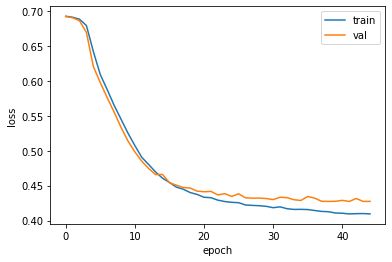

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련 손실과 검증 손실의 차이가 좁혀졌습니다.

## **2개의 층을 연결하기**

순환층을 연결할 때 주의할 점이 있습니다. 순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달합니다. 여기에 순환층을 추가하면 모든 순환층에 순차 데이터가 필요합니다. 따라서 이전 순환층이 모든 타임스텝의 은닉 상태를 출력해야 하고, 추가한 순환층(마지막 순환층)만 마지막 타임스텝의 은닉 상태를 출력해야 합니다. 이를 과정을 구현하려면 매개변수 `return_sequences`를 `True`로 설정합니다. 아래 코드로 구현해 보겠습니다.

In [ ]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
# 첫 번째 LSTM 층입니다. 모든 타임스텝의 은닉 상태를 출력합니다.
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
# 마지막 LSTM 층입니다. 마지막 타임스텝의 은닉 상태를 출력합니다.
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


첫 번째 LSTM 층은 모든 타임스텝 100개의 은닉 상태를 출력하므로 (None, 100, 8)이고, 마지막 LSTM 층은 마지막 타임스텝의 은닉 상태만 출력하므로 (None, 8)입니다.

모델을 훈련해 보겠습니다. 위에서 사용했던 코드 형식과 같습니다.

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 33s 91ms/step - loss: 0.6929 - accuracy: 0.5145 - val_loss: 0.6923 - val_accuracy: 0.5726
Epoch 2/100
313/313 [==============================] - 26s 84ms/step - loss: 0.6905 - accuracy: 0.6017 - val_loss: 0.6868 - val_accuracy: 0.6742
Epoch 3/100
313/313 [==============================] - 28s 89ms/step - loss: 0.6625 - accuracy: 0.6730 - val_loss: 0.6164 - val_accuracy: 0.6904
Epoch 4/100
313/313 [==============================] - 30s 96ms/step - loss: 0.6030 - accuracy: 0.6969 - val_loss: 0.5833 - val_accuracy: 0.7248
Epoch 5/100
313/313 [==============================] - 29s 91ms/step - loss: 0.5803 - accuracy: 0.7181 - val_loss: 0.5675 - val_accuracy: 0.7362
Epoch 6/100
313/313 [==============================] - 27s 87ms/step - loss: 0.5639 - accuracy: 0.7321 - val_loss: 0.5479 - val_accuracy: 0.7490
Epoch 7/100
313/313 [==============================] - 27s 85ms/step - loss: 0.5467 - accuracy: 0.7452 - val_loss: 0.5325 - val_ac

일반적으로 순환층을 쌓으면 성능이 높아지지만 이 예제에서는 효과가 없었습니다.

훈련 손실과 검증 손실 그래프를 시각화해 보겠습니다.

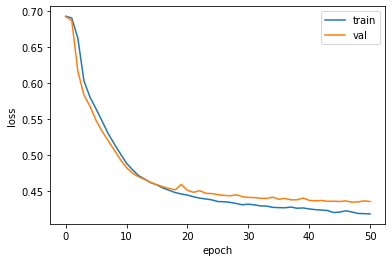

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

순환층을 1개 사용한 경우보다 과대적합을 잘 제어하면서 손실을 더 낮춘 형태입니다. 

## **GRU 구조**

GRU는 LSTM의 간소화 버전입니다. LSTM처럼 셀 상태를 계산하지 않고 은닉 상태 하나만 포함합니다. Gated Recurrent Unit은 말 그대로 게이트가 순환하는 것을 의미합니다. 아래 그림(출처: 본서)을 제시하겠습니다.

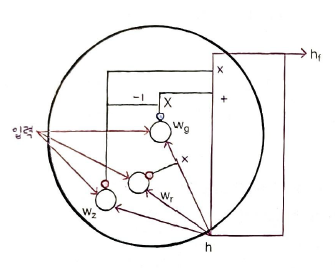

GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀 3개가 포함됩니다. 2개는 시그모이드 활성화 함수를 사용하고 나머지 하나는 tanh 활성화 함수를 사용합니다. 여기에서도 은닉 상태와 입력에 곱해지는 가중치를 합쳐서 나타냈습니다. 

## **GRU 신경망 훈련하기**

GRU를 사용하여 순환층을 생성해 보겠습니다. 참고로 `GRU` 클래스도 `LSTM` 클래스처럼 매개변수 `dropout`과 `return_sequences`를 가집니다. 사용법은 동일합니다.

In [ ]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


GRU 셀에는 작은 셀 3개가 존재합니다. 작은 셀에는 입력과 은닉 상태에 곱하는 가중치와 절편이 있습니다. 입력에 곱하는 가중치는 16 x 8 = 128개이고, 은닉 상태에 곱하는 가중치는 8 x 8 = 64개입니다. 절편은 유닛마다 하나씩이므로 8개입니다. 모두 더하면 200개이며, 작은 셀 3개가 존재하므로 200 x 3 = 600개입니다. 그러나 24개가 덜 카운트된 개수입니다. 624개인 이유를 살펴보겠습니다. 텐서플로에 기본적으로 구현된 GRU 셀의 계산은 바로 위에 첨부한 그림과 다른 방식으로 이뤄집니다. GRU 셀의 초기 버전은 아래 그림(출처: 본서)처럼 계산됩니다.

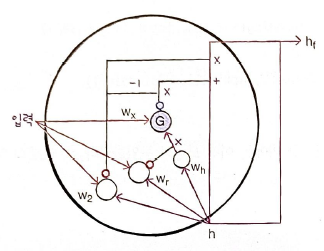





그림 중앙에 위치한 입력 부분인 G가 기존 그림과 다른 지점입니다. 기존 그림에서는 가운데 셀의 출력과 은닉 상태가 곱해지고 G 셀에 입력됐습니다. 그러나 이 그림에서는 은닉 상태가 먼저 가중치와 곱해지고 가운데 셀의 출력과 곱해집니다. 기존 그림에서는 입력과 은닉 상태에 곱해지는 가중치를 $w_g$로 표기했지만 이 그림에서는 $w_x$와 $w_h$로 나눴습니다. 이렇게 나눠서 계산하면 은닉 상태에 곱해지는 가중치 외에 절편이 따로 필요합니다. 따라서 작은 셀마다 절편이 하나씩 추가되고 유닛 8개가 있으므로 모델 파라미터가 총 24개만큼 더해져 624개가 됩니다. 텐서플로는 GPU를 잘 사용할 목적으로 이 계산 방식을 채용했습니다. 그러나 대부분 GRU 셀을 소개할 때 기존 그림을 사용합니다. 통용되는 이론과 구현이 차이가 나는 경우가 존재하는 이유입니다.

GRU 셀을 사용한 순환 신경망을 훈련해 보겠습니다. 위 과정들과 같습니다.

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 47ms/step - loss: 0.6926 - accuracy: 0.5289 - val_loss: 0.6918 - val_accuracy: 0.5638
Epoch 2/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6906 - accuracy: 0.5762 - val_loss: 0.6895 - val_accuracy: 0.5832
Epoch 3/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6874 - accuracy: 0.5977 - val_loss: 0.6859 - val_accuracy: 0.6012
Epoch 4/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6826 - accuracy: 0.6122 - val_loss: 0.6807 - val_accuracy: 0.6106
Epoch 5/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6756 - accuracy: 0.6225 - val_loss: 0.6729 - val_accuracy: 0.6142
Epoch 6/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6652 - accuracy: 0.6321 - val_loss: 0.6619 - val_accuracy: 0.6200
Epoch 7/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6510 - accuracy: 0.6452 - val_loss: 0.6468 - val_ac

LSTM과 비슷한 성능입니다.

훈련 손실과 검증 손실을 그래프화해 보겠습니다.

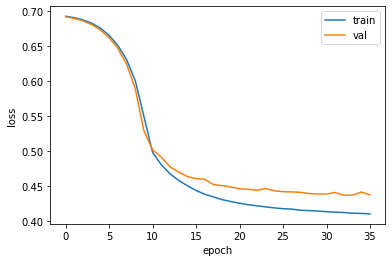

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련 과정이 잘 수렴됩니다. 다만 드롭아웃을 사용하지 않았으므로 이전보다 손실 간 차이가 큽니다. 

## **LSTM과 GRU 셀로 훈련**

위에서 가장 괜찮은 성능을 보였던 순환층 2개의 모델을 로드하여 테스트 데이터 세트에 대한 성능을 확인해 보겠습니다. 

In [ ]:
test_seq = pad_sequences(test_input, maxlen=100)

rnn_model = keras.models.load_model('best-2rnn-model.h5')
rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 13s 15ms/step - loss: 0.4298 - accuracy: 0.8003


[0.4298435151576996, 0.800279974937439]

드롭아웃을 적용하여 과대적합을 억제했으므로 검증 데이터 세트의 성능과 테스트 데이터 세트의 성능이 비슷합니다. 